<a href="https://colab.research.google.com/github/seanreed1111/colab-demos/blob/master/abe_2009_pyro_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

see also: 
- "COUNTING YOUR CUSTOMERS” ONE BY ONE: A Hierarchical Bayes Extension to the Pareto/NBD Model Abe 2009 http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.687.3554&rep=rep1&type=pdf

- https://github.com/mplatzer/BTYDplus

- Numpyro adventures in covariance https://colab.research.google.com/drive/1pQptn66Ir-Jesph-1CRf5OZ-TmaiZWH5#scrollTo=mDJFmLo8ZUKz


In [1]:
# installlation required
!pip install -q pyro-ppl=='1.8.0'


     |████████████████████████████████| 713 kB 4.9 MB/s 


<a id = "7"></a><br>
# LIBRARIES

In [2]:
import os
import datetime as dt
import pandas as pd
pd.set_option('display.max_rows', 50)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.stats import expon, poisson, uniform, lognorm

from numpy.random import Generator, PCG64
numpy_randomGen = Generator(PCG64(seed=1))


import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.optim import ClippedAdam

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 4]


In [3]:
logging.basicConfig(level=logging.DEBUG)

## Helper Functions

### Truncated Exponential

In [ ]:
import pyro.distributions as dist
from torch.distributions.utils import broadcast_all

def TruncatedExponential(low, high, rate=1.0):
    '''
    Usage: 
    d = TruncatedExponential(3, 10, 1.0).sample([1000])
    sns.displot(data=d)
    '''
    low, high, rate = broadcast_all(low, high, rate)
    return dist.TransformedDistribution(
        dist.Uniform((-rate * high).exp(), (-rate * low).exp()),
        [dist.transforms.ExpTransform().inv,
         dist.transforms.AffineTransform(loc=0, scale=-1/rate)]
    )


In [ ]:
covs = torch.tensor([[2., -1.], [-1.,3.]])
dist.MultivariateNormal(tensor([0.,0.]),covariance_matrix=covs).sample([5])

tensor([[-0.7182, -1.3469],
        [ 1.5743, -2.6597],
        [-1.9787,  1.5368],
        [-0.7229, -2.2143],
        [ 0.3651, -2.2745]])

In [ ]:
sigma = dist.Exponential(1).expand([2]).sample()
rho = dist.LKJ(2, 2).sample()
cov = torch.outer(sigma, sigma)*rho

tensor([[0.0013, 0.0066],
        [0.0066, 0.6447]])

In [ ]:
dist.Normal(0,3).expand([2]).to_event(1).sample()

tensor([ 0.1741, -8.4035])

In [ ]:
mu_covariates = torch.ones([1,3])
beta_mus = dist.Normal(0,5).expand([mu_covariates.size(1)]).to_event(1).sample().unsqueeze(-1)

lambda_covariates = torch.ones([1,3])
beta_lambdas = dist.Normal(0,3).expand([lambda_covariates.size(1)]).to_event(1).sample().unsqueeze(-1)

In [ ]:
lambda_covariates, beta_lambdas, torch.mm(lambda_covariates, beta_lambdas)

(tensor([[1., 1., 1.]]),
 tensor([ 1.1304, -2.6500, -2.1475]),
 tensor([-3.6671]))

In [ ]:
mu_covariates, beta_mus, torch.mm(mu_covariates ,beta_mus)

(tensor([[1., 1., 1.]]), tensor([[ 2.5492],
         [-1.9735],
         [ 3.8888]]), tensor([[4.4645]]))

In [ ]:
beta_mus.size()

torch.Size([3])

In [ ]:
torch.ones([10,3])

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [ ]:
torch.ones([1,1]), torch.ones(1)

(tensor([[1.]]), tensor([1.]))

In [ ]:
#parameters from RFM (x, tx, Tcal)
#for each customer we will have: repeat_purchases x, date of last purchase tx, period of observation Tcal from first purchase to time of measurement ]  

def btyd_abe_model(*, x, tx, Tcal, lambda_covariates = None, mu_covariates = None, prior_only=True):
  '''
  x: number of REPEAT purchases after the first. Must be > 0.
  tx: date of last purchase
  Tcal: observation date
  lambda_covariates: 
  mu_covariates:
  prior_only:

  returns: Not a pure function, needed for sampling and pyro param store
  '''
  N = x.size(0) #num of customers

  if lambda_covariates is None:
    lambda_covariates = torch.ones([N,1]) #intercept only
  else:#TODO might need to unsqueeze the lambda_covariates if it is not 2D
    lambda_covariates = torch.hstack((torch.ones([N,1], lambda_covariates)))

  if mu_covariates is None:
    mu_covariates = torch.ones([N,1]) #intercept only
  else: #TODO might need to unsqueeze the lambda_covariates if it is not 2D
    mu_covariates = torch.hstack((torch.ones([N,1], lambda_covariates)))

  z = None #TODO FIX
  y = None #TODO FIX

  #TODO Convert original pareto/NBD loglik function :==> non-centered Pareto/NBD Abe 2009 formulation
  def loglik(*, lambda_, mu, x, tx, Tcal, y, z):
    target = x * torch.log(lambda_) - torch.log(lambda_ + mu)
    n = lambda_.size(0)
    for i in range(n):
      target  = target + torch.logaddexp(torch.log(lambda_[i]) - (lambda_[i] + mu[i]) * Tcal[i],
                                        torch.log(mu[i]) - (lambda_[i] + mu[i]) * tx[i]
                                        )
    return target
  
  sigmas = pyro.sample('sigmas', dist.Exponential(1).expand([2]))
  rho = pyro.sample('rho', dist.LKJ(2, 2))
  cov = torch.outer(sigmas, sigmas)*rho

  # mu_mean # TODO can initialize w/informed prior using average computed from data
  # lambda_mean # TODO can initialize w/informed prior using average computed from data


  beta_mus = pyro.sample('beta_mus', dist.Normal(0,3).expand([N, mu_covariates.size(1)]))
  beta_lambdas = pyro.sample('beta_lambdas', dist.Normal(0,3).expand([N, lambda_covariates.size(1)]))
  mu_mean, lambda_mean = 0., 0. #TODO fix #mu_mean, lambda_mean = torch.mm(torch.t(mu_covariates), beta_mus), torch.mm(torch.t(lambda_covariates), beta_lambdas)
  with pyro.plate('data', N):
    mu_lambda = pyro.sample('mu_lambda', dist.MultivariateNormal(tensor([mu_mean, lambda_mean]), cov)).exp()

  mu, lambda_ = mu_lambda[:,0], mu_lambda[:,1]
  mu_plus_lambda = mu + lambda_

  if not prior_only:
    # sample z
    # sample dropout time y from double truncated exponential if z == 0
    # compute loglik using mu, lambda_, z, and y . Note z and y are same shape as x, tx, and Tcal
    pyro.factor('loglik', loglik(lambda_, mu,x, tx, Tcal)


In [ ]:
x, tx, Tcal = tensor([2.,3., 4., 5.]), tensor([2.,3., 4., 5.]), tensor([2.,3., 4., 5.])
dat = {'x':x, 'tx':tx, 'Tcal':Tcal}

from pyro.infer import MCMC, NUTS
model = btyd_abe_model
mcmc = MCMC(NUTS(model), num_samples=100, warmup_steps=200)

mcmc.run(**dat, prior_only=True)

Sample: 100%|██████████| 300/300 [02:10,  2.29it/s, step size=9.76e-02, acc. prob=0.927]


In [ ]:
samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
hmc_samples.keys()

dict_keys(['beta_lambdas', 'beta_mus', 'mu_lambda', 'rho', 'sigmas'])

In [ ]:
hmc_samples['sigmas'].shape

(100, 2)

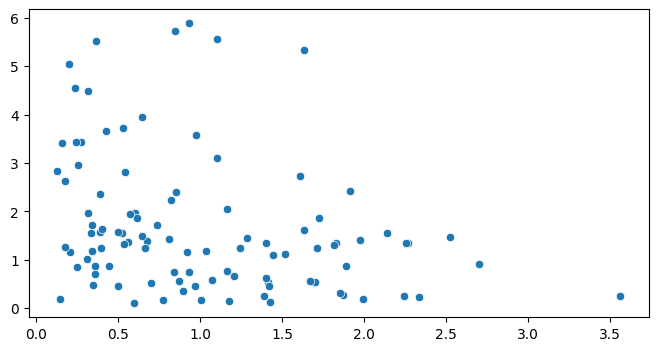

In [ ]:
sns.scatterplot(x=hmc_samples['sigmas'][:, 0], y=hmc_samples['sigmas'][:,1]);

### Text1

### Text2

### Text3

### Description of the simulation model

Let’s describe the model first by simulation. 

Suppose we have a company that is 2 years old and a total of 2000 customers, C, that have made at least one purchase from us. 

We’ll assume a linear rate of customer acquisition, so that the first purchase date is simply a uniform random variable over the 2 years of the company existance. These assumptions are just to keep the example concrete, and are not so important for understanding the model.

Each customer c∈C is assumed to have a certain lifetime, τc, starting on their join-date. 

During their lifetime, they will purchase at a constant rate, λc, so that they will make k∼Poisson(tλc) purchases over a time-interval t. 

Once their lifetime is over, they will stop purchasing. We only observe the customer for Tc units of time, and this observation time can be either larger or smaller than the lifetime, τc. 

Since we don’t observe τc itself, we will assume it follows an exponential distribution, i.e. τc∼Exp(μc).

In [ ]:
def create_start_dates(n, max_number_of_periods):
  '''
  returns an array of n start dates in interval [0, max_number_of_periods)
  
  inputs 
  int n: number of customers to generate
  int max_number_of_periods: max number of periods customer can be observed in simulation

  output: 
  start_date[n]: starting period of customer n, starting from 0
  '''
  return np.random.default_rng(1).integers(low=0, high=max_number_of_periods, size=n)

In [ ]:
def simulate_purchases(*,T, mean_customer_lifetime, 
                       mean_period_between_purchases,
                       max_number_of_periods,
                       var_customer_lifetime = None, 
                       var_period_between_purchases = None 
                        ):
  '''
  input: 
  T: customer enrollment date

  mean_customer_lifetime: mean of customer lifetime, in periods
  var_customer_lifetime: var of customer lifetime
  mean_period_between_purchases: mean period between purchases
  var_period_between_purchases: var of period between purchases

  output:
  k: number of purchases
  T: customer enrollment date
  obs_time = This is the length of time they have been a customer, max_number_of_periods - T
  tau: actual (latent) lifetime for this customer (drawn from exponential distribution with scale=mean_customer_lifetime)
  mean_customer_lifetime: mean_customer_lifetime
  1./mean_customer_lifetime :  reciprocal of mean customer lifetime
  '''
  from scipy.stats import expon
  
  obs_time = max_number_of_periods - T
  assert obs_time > 0, "time as enrolled customer cannot be negative"
  assert mean_customer_lifetime > 0 , "mean customer lifetime must be > 0"
  assert mean_period_between_purchases > 0, "mean period between purchases must be > 0"
  
  tau = expon.rvs(scale=mean_customer_lifetime) # actual lifetime for this customer
  t, k = T, 0 
  wait = expon.rvs(scale=mean_period_between_purchases) # waiting time between purchases
  while ((t + wait) < min(max_number_of_periods, T + tau)): 
    t = t + wait
    k = k + 1
    wait = expon.rvs(scale=mean_period_between_purchases)

  return  T,  obs_time, k, tau, t, mean_customer_lifetime, 1./mean_customer_lifetime  #final value of t is time of last purchased

simulate_purchases_vec = np.vectorize(simulate_purchases)




In [ ]:
simulate_purchases(T=20.,
                   max_number_of_periods=100.,
                   mean_customer_lifetime=30.,
                   mean_period_between_purchases=8.
                   )

In [ ]:
def create_customer_df(*,
                       n, 
                       mean_customer_lifetime, 
                       mean_period_between_purchases, 
                       max_number_of_periods, 
                       var_customer_lifetime = None, 
                       var_period_between_purchases = None
                       ):
  '''
  output: 
    dataframe[['enrollment_date', 
    'T_observed',
    'purchases', 
    'tau', : lifetime for this simulated customer drawn from exponential distribution with scale=mean_customer_lifetime
    'date_of_last_purchase', 
    'mean_customer_lifetime',
    '1/mean_customer_lifetime'

  '''
  T =  create_start_dates(n=n, max_number_of_periods=max_number_of_periods)
  result = np.round(
      simulate_purchases_vec(T=T, 
                             mean_customer_lifetime=mean_customer_lifetime, 
                             mean_period_between_purchases=mean_period_between_purchases,
                             max_number_of_periods=max_number_of_periods

                             )
          ,2)
  return pd.DataFrame(result, index=['enrollment_date', 
                                     'T_observed',
                                     'purchases', 
                                     'tau', 
                                     'date_of_last_purchase', 
                                     'mean_customer_lifetime',
                                     '1/mean_customer_lifetime']).T


In [ ]:
max_number_of_periods=60
customers = create_customer_df(n=20, 
                               mean_customer_lifetime=30, 
                               mean_period_between_purchases=8, 
                               max_number_of_periods=max_number_of_periods)
customers

In [ ]:
customers.describe().T

In [ ]:
data = customers[customers['purchases'] >= 2.].copy()
data.describe().T

In [ ]:
t, T, k = tensor(data['date_of_last_purchase'].values), tensor(data['T_observed'].values), tensor(data['purchases'].values)

In [ ]:
data=dist.Gamma(concentration=2, rate=1).expand([1000]).sample()
print(data.min(),  data.median(), data.mean(),data.max(), data.var())
sns.displot(data=data);

In [ ]:
# Inverse Gamma: for concentration > 2, 
#     mean = rate/(concentration - 1)
#      var ~ concentration^2 / rate ^3
#     MEDIAN  ~ rate / concentration

# Gamma:
# mean = concentration / rate
# var = concentration / rate ^2

data=dist.InverseGamma(concentration=7,rate=70.).expand([10000]).sample()

print(data.min(),  data.median(), data.mean(), data.max(), data.var())
sns.displot(data=data);

In [ ]:
data=dist.HalfNormal(scale=200).expand([10000]).sample()

print(data.min(),  data.median(), data.mean(), data.max(), data.var())
sns.displot(data=data);

## Model Definition

In [ ]:
# def model_half_normal_priors(t, T, k, prior_only=False):
#   '''
#   input:
#   vector t (nx1)  = time since most recent purchase (recency)
#   vector T (nx1) = total observation time
#   vector k (nx1) = number of purchases observed (k must be >= 2)

#   n, etau_alpha, etau_beta, Lambda_alpha, Lambda_beta are scalars
#   n = number of customers
#   etau_alpha, etau_beta are priors for etau
#   Lambda_alpha, Lambda_beta are priors for Lambda
#   '''
#   assert torch.all(k >=2.), "There are illegal values of k. k must be >= 2"

#   def loglik(Lambda, mu, t, T, k):
#     target = k * torch.log(Lambda) - torch.log(Lambda + mu)
#     n = Lambda.size(0)
#     for i in range(n):
#       target  = target + torch.logaddexp(torch.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
#                                         torch.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
#                                         )
#     return target
  
#   etau_alpha = pyro.sample('tau_alpha', dist.HalfNormal(scale=1))
#   etau_beta = pyro.sample('tau_beta', dist.HalfNormal(scale=200))
#   Lambda_alpha = pyro.sample('Lambda_alpha', dist.HalfNormal(scale=1))
#   Lambda_beta = pyro.sample('Lambda_beta', dist.HalfNormal(scale=200))

#   if not prior_only:
#     with pyro.plate("data", t.size(0)):
#       etau  = pyro.sample('etau', dist.InverseGamma(etau_alpha, etau_beta)) #mean lifetime
#       mu = pyro.deterministic('mu', 1./tau)
#       Lambda = pyro.sample('Lambda', dist.Gamma(Lambda_alpha, Lambda_beta))
#       one_over_Lambda = pyro.deterministic('one_over_Lambda', 1./Lambda)
#     pyro.factor('loglik', loglik(Lambda, mu, t, T, k))

In [ ]:
# def model_test(t, T, k, prior_only=False):
#   '''
#   input:
#   vector t (nx1)  = time since most recent purchase (recency)
#   vector T (nx1) = total observation time
#   vector k (nx1) = number of purchases observed (k must be >= 2)

#   n, etau_alpha, etau_beta, Lambda_alpha, Lambda_beta are scalars
#   n = number of customers
#   etau_alpha, etau_beta are priors for etau
#   Lambda_alpha, Lambda_beta are priors for Lambda
#   '''
#   assert torch.all(k >=2.), "There are illegal values of k. k must be >= 2"

#   def loglik(Lambda, mu, t, T, k):
#     target = k * torch.log(Lambda) - torch.log(Lambda + mu)
#     n = Lambda.size(0)
#     for i in range(n):
#       target  = target + torch.logaddexp(torch.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
#                                         torch.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
#                                         )
#     return target
  
#   etau_alpha = pyro.sample('tau_alpha', dist.HalfCauchy(scale=2))
#   etau_beta = pyro.sample('tau_beta', dist.HalfCauchy(scale=2), constraint=constraints.positive)
#   Lambda_alpha = pyro.sample('Lambda_alpha', dist.HalfCauchy(scale=2), constraint=constraints.positive)
#   Lambda_beta = pyro.sample('Lambda_beta', dist.HalfCauchy(scale=2), constraint=constraints.positive)

#   if not prior_only:
#     with pyro.plate("data", t.size(0)):
#       etau  = pyro.sample('etau', dist.InverseGamma(etau_alpha, etau_beta)) #mean lifetime
#       mu = pyro.deterministic('mu', 1./tau)
#       Lambda = pyro.sample('Lambda', dist.Gamma(Lambda_alpha, Lambda_beta))
#       one_over_Lambda = pyro.deterministic('one_over_Lambda', 1./Lambda)
#     pyro.factor('loglik', loglik(Lambda, mu, t, T, k))

In [ ]:
from pyro.infer import MCMC, NUTS
model = model_half_normal_priors
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=250)

mcmc.run(t, T, k, prior_only=True)

In [ ]:
samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
hmc_samples.keys()

In [ ]:
model = model_test
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=250)

mcmc.run(t, T, k, prior_only=False)

In [ ]:
samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
keys = hmc_samples.keys()

In [ ]:
for key in keys:
  print(key, hmc_samples[key].shape)

In [ ]:
store = pyro.get_param_store()
for key in store.keys():
  print(key, store[key])

## sidebar

In [ ]:
Lambda = pd.DataFrame(hmc_samples['Lambda'])
mu = pd.DataFrame(1. /hmc_samples['Lambda'])
tau = pd.DataFrame(hmc_samples['tau'])

In [ ]:
pd.set_option('display.max_rows', 20)

In [ ]:
Lambda.describe().T

In [ ]:
mu.describe().T

In [ ]:
tau.describe().T

In [ ]:
data

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
pd.concat([data.reset_index(),mu.describe().T ], axis=1) # is this valid? IDK

In [ ]:
pd.concat([data.reset_index(),tau.describe().T ], axis=1)

In [ ]:
# model = model_test
# nuts_kernel_jit = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
# mcmc_jit = MCMC(nuts_kernel_jit, num_samples=1000, warmup_steps=250)

# mcmc_jit.run(t, T, k, prior_only=False)

## original model

In [ ]:
def model_one(t, T, k, prior_only=False):
  '''
  input:
  vector t (nx1)  = time since most recent purchase (recency)
  vector T (nx1) = total observation time
  vector k (nx1) = number of purchases observed (k must be >= 2)

  n, etau_alpha, etau_beta, Lambda_alpha, Lambda_beta are scalars
  n = number of customers
  etau_alpha, etau_beta are priors for etau
  Lambda_alpha, Lambda_beta are priors for Lambda
  '''
  assert torch.all(k >=2.), "There are illegal values of k. k must be >= 2"

  def loglik(Lambda, mu, t, T, k):
    target = k * torch.log(Lambda) - torch.log(Lambda + mu)
    n = Lambda.size(0)
    for i in range(n):
      target  = target + torch.logaddexp(torch.log(Lambda[i]) - (Lambda[i] + mu[i]) * T[i],
                                        torch.log(mu[i]) - (Lambda[i] + mu[i]) * t[i]
                                        )
    return target
  
  # etau_alpha = pyro.sample('etau_alpha', dist.)
  # etau_beta = pyro.sample('etau_beta', dist)
  # Lambda_alpha = pyro.sample('Lambda_alpha', dist)
  # Lambda_beta = pyro.sample('Lambda_beta', dist)

  with pyro.plate("data", t.size(0)):
    etau  = pyro.sample('etau', dist.InverseGamma(etau_alpha, etau_beta))
    mu = 1./etau
    Lambda = pyro.sample('Lambda', dist.Gamma(Lambda_alpha, Lambda_beta))

  if prior_only:
    pyro.factor('loglik', loglik(Lambda, mu, t, T, k))
  else:
    pyro.factor('zero', 0)

## create data

## Perform MCMC

In [ ]:
from pyro.infer import MCMC, NUTS
model = model_test
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=250)

mcmc.run(t, T, k, prior_only=True)

In [ ]:
samples = mcmc.get_samples()
hmc_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
hmc_samples.keys()

In [ ]:
for key in hmc_samples.keys():
  sns.kdeplot(data = hmc_samples[key])

## Centered BTYD

In [ ]:

# https://www.briancallander.com/posts/customer_lifetime_value/models/rf.stan
# data_hyperpriors <- list(
#   log_life_mean_mu = log(31),
#   log_life_mean_sigma = 0.7,
#   log_life_scale_sigma = 0.8,

#   log_lambda_mean_mu = log(1 / 14),
#   log_lambda_mean_sigma = 0.3,
#   log_lambda_scale_sigma = 0.5
# )
data {
  int<lower = 1> n;       // number of customers
  vector<lower = 0>[n] t; // time to most recent purchase
  vector<lower = 0>[n] T; // total observation time
  vector<lower = 0>[n] k; // number of purchases observed

  // user-specified parameters
  real<lower = 0> etau_mean_alpha;
  real<lower = 0> etau_mean_beta;
  real<lower = 0> etau_sd_alpha;
  real<lower = 0> etau_sd_beta;

  real<lower = 0> lambda_mean_alpha;
  real<lower = 0> lambda_mean_beta;
  real<lower = 0> lambda_sd_alpha;
  real<lower = 0> lambda_sd_beta;
}

parameters {
  vector<lower = 0>[n] lambda; // purchase rate
  vector<lower = 0>[n] etau;   // expected mean lifetime

  vector<lower = 0>[n] etau_mean; // mean expected life span
  vector<lower = 0>[n] etau_sd;
  vector<lower = 0>[n] lambda_mean; // mean purchase rate
  vector<lower = 0>[n] lambda_sd;

}

transformed parameters {
  vector<lower = 0>[n] etau_beta = etau_mean;
  vector<lower = 0>[n] etau_alpha = etau_sd;
  vector<lower = 0>[n] lambda_beta = lambda_mean ./ (lambda_sd .* lambda_sd);
  vector<lower = 0>[n] lambda_alpha = lambda_beta .* lambda_mean;

  vector<lower = 0>[n] mu = 1.0 ./ etau;
}

model {
  // hyperpriors
  etau_mean ~ gamma(etau_mean_alpha, etau_mean_beta);
  etau_sd ~ gamma(etau_sd_alpha, etau_sd_beta);

  lambda_mean ~ gamma(lambda_mean_alpha, lambda_mean_beta);
  lambda_sd ~ gamma(lambda_sd_alpha, lambda_sd_beta);

  // priors
  etau ~ inv_gamma(etau_alpha, etau_beta);
  lambda ~ gamma(lambda_alpha, lambda_beta);

  // likelihood
  target += k .* log(lambda) - log(lambda + mu);
  for (i in 1:n) {
    target += log_sum_exp(
      log(lambda[i]) - (lambda[i] + mu[i]) .* T[i],
      log(mu[i]) - (lambda[i] + mu[i]) .* t[i]
    );
  }
}


## Non-centered BTYD

In [ ]:
# non-centered BTYD
# https://www.briancallander.com/posts/customer_lifetime_value/recency_frequency.html
# https://www.briancallander.com/posts/customer_lifetime_value/models/rf_noncentred.stan

data {
  int<lower = 1> n;       // number of customers
  vector<lower = 0>[n] t; // time between first and last purchase
  vector<lower = 0>[n] T; // total observation time
  vector<lower = 0>[n] k; // number of purchases

  // hyperparameters for the expected lifetime
  real log_life_mean_mu;
  real<lower = 0> log_life_mean_sigma;
  // hyperparameter for scale of customer-level lifetime effects
  real<lower = 0> log_life_scale_sigma;

  // hyperparameters for the expected purchase rate
  real log_lambda_mean_mu;
  real<lower = 0> log_lambda_mean_sigma;
  // hyperparameter for scale of customer-level purchase-rate effects
  real<lower = 0> log_lambda_scale_sigma;

  // flag whether to only sample from the prior
  // to draw from the prior-predictive distribution: prior_only = 1
  // to draw from the posterior distribution: prior_only = 0
  int<lower = 0, upper = 1> prior_only;
}

transformed data {
  vector<lower = 0, upper = 0>[2] zero = rep_vector(0, 2);
  vector[2] J = [-1, 1]';
  vector[2] m = [log_life_mean_mu, log_lambda_mean_mu]';
  matrix<lower = 0>[2, 2] m_sigma = diag_matrix([log_life_mean_sigma, log_lambda_mean_sigma]');
  matrix<lower = 0>[2, 2] s_sigma = diag_matrix([log_life_scale_sigma, log_lambda_scale_sigma]');
}

parameters {
  row_vector[2] log_centres;
  vector<lower = 0>[2] scales;
  matrix[n, 2] customer; // customer-level effects
}

transformed parameters {
  matrix<lower = 0>[n, 2] theta = exp(
    diag_post_multiply(
      rep_matrix(log_centres, n) + diag_post_multiply(customer, scales),
      J
    )
  ); // (mu, lambda)
}

model {
  // priors
  log_centres ~ multi_normal_cholesky(m, m_sigma);
  scales ~ multi_normal_cholesky(zero, s_sigma);

  for (i in 1:n) {

    customer[i, ] ~ std_normal();

    // likelihood
    if (prior_only == 0) {
      target += log_sum_exp(
        log(theta[i, 2]) - (theta[i, 2] + theta[i, 1]) .* T[i],
        log(theta[i, 1]) - (theta[i, 2] + theta[i, 1]) .* t[i]
      );
    }
  }

  if (prior_only == 0) {
    target += k .* log(theta[, 2]) - log(theta[, 2] + theta[, 1]);
  }

}
